This notebook is used to:
1. load preprocessed data, normalized and get searchlight neighbors
2. Perform pattern fidelity calculation for each searchlight
3. Result analysis and visualization

In [22]:
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.stats import pearsonr, ttest_ind
from joblib import Parallel, delayed
from sklearn.neighbors import NearestNeighbors
from nilearn.image import math_img
from nilearn import image, plotting
import matplotlib.pyplot as plt

### 1. load preprocessed data and get searchlight

In [2]:
# read-in data
final_recall = np.load('data/free_recall_mat_filtered.npy')         # [n_subs, n_pics]
final_data = np.load('data/full_encoding_data_flat_filtered.npy')   # [n_subs, n_pics, n_voxels]
n_subs, n_pics, n_voxels = final_data.shape
print("z-scoring...")
X_norm = np.zeros_like(final_data)
# normalize
for s in range(n_subs):
    sub_dat = final_data[s, :, :]
    # mean and std across pic
    mean_vec = np.mean(sub_dat, axis=0)
    std_vec = np.std(sub_dat, axis=0)
    std_vec[std_vec == 0] = 1.0
    X_norm[s, :, :] = (sub_dat - mean_vec) / std_vec

z-scoring...


In [ ]:
# get searchlight index
mask_img = nib.load("atlas/mask_all_valid_voxels.nii.gz")
mask_data = mask_img.get_fdata()
mask_bool = mask_data.astype(bool) 
mask_coords = np.where(mask_data != 0)
mask_coords = np.vstack(mask_coords).T # (n_voxels, 3) 3 for x,y,z
# use KNN to find neighbors
radius_vox = 3.1
nn = NearestNeighbors(radius=radius_vox)
nn.fit(mask_coords)
# radius_neighbors return each voxel's neighbors' row index in mask_coords
# aligh to beta[mask_bool, :, :]
neighbor_indices = nn.radius_neighbors(mask_coords, return_distance=False)
print(f"searchlight neighbors get: {len(neighbor_indices)}")

searchlight neighbors get: 42699


### 2. Searchlight main function and similarity calc

In [ ]:
# similarity calculation function
def process_searchlight_sphere(sphere_data, recall_matrix):
    """
    sphere_data:shape (n_subs, n_pics, n_voxels_in_sphere) 
                data in searchlight
    recall_matrix: shape (n_subs, n_pics) 
                recall labels
    
    Returns:
        t_score: similairty t test
    """
    n_subs, n_pics, n_voxels = sphere_data.shape
    
    # result save: (n_subs, n_pics) similarity matrix
    similarity_matrix = np.full((n_subs, n_pics), np.nan)
    
    # --- Loop Pictures ---
    for p in range(n_pics):
        # who Recall=1
        idx_recallers = np.where(recall_matrix[:, p] == 1)[0]
        n_recallers = len(idx_recallers)
        current_pic_data = sphere_data[:, p, :]
        # calc all Recallers Sum, preparing later LOO
        # sum_recallers shape: [n_voxels,]
        sum_recallers = np.sum(current_pic_data[idx_recallers, :], axis=0)
        
        # --- Loop Subjects ---
        for s in range(n_subs):
            subject_pattern = current_pic_data[s, :]
            if np.std(subject_pattern) == 0:
                continue
            # === Leave-One-Out Template ===
            if recall_matrix[s, p] == 1:
                # if recall, pattern = (sum - sub) / (N - 1)
                template_pattern = (sum_recallers - subject_pattern) / (n_recallers - 1)
            else:
                # if forget, pattern = sum / N
                template_pattern = sum_recallers / n_recallers
            
            # pattern valid?
            if np.std(template_pattern) == 0:
                continue
                
            # Pearson Correlation
            r_val = np.corrcoef(subject_pattern, template_pattern)[0, 1]
            # Fisher-Z, transform to normal distribution
            similarity_matrix[s, p] = np.arctanh(np.clip(r_val, -0.999, 0.999))
            
    # --- t-test on similarity score ---
    # similarity_matrix (X) 和 recall_matrix (Y)
    # compare Sim(Recalled) vs. Sim(Non-recalled)
    # get data
    mask_valid = ~np.isnan(similarity_matrix)
    y_labels = recall_matrix[mask_valid]
    x_sims = similarity_matrix[mask_valid]
    if len(x_sims) < 10:
        return 0.0, 1.0
    sims_R = x_sims[y_labels == 1]
    sims_F = x_sims[y_labels == 0]
    if len(sims_R) < 3 or len(sims_F) < 3:
        return 0.0, 1.0
    # t-test
    t_stat, p_val = ttest_ind(sims_R, sims_F, equal_var=False, alternative='greater')
    if np.isnan(t_stat):
        return 0.0, 1.0
        
    return t_stat, p_val

# Wrapper for one run
def run_one_voxel(voxel_idx, neighbors, full_data, recall_mat):
    # get neighbor beta
    sphere_data = full_data[:, :, neighbors] # [sub, pic, voxels]
    # run core function
    t_score, p_val = process_searchlight_sphere(sphere_data, recall_mat)
    return voxel_idx, t_score, p_val

In [ ]:
# test one sample run
for i, idxs in enumerate(neighbor_indices):
    test_vidx, test_t_score, test_p_val = run_one_voxel(i, idxs, X_norm, final_recall)

In [ ]:
# --- parallel running --
results = Parallel(n_jobs=12, verbose=5)(
    delayed(run_one_voxel)(i, idxs, X_norm, final_recall) 
    for i, idxs in enumerate(neighbor_indices)
)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    6.5s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   11.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   17.0s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:   25.3s
[Parallel(n_jobs=12)]: Done 858 tasks      | elapsed:   36.5s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:   48.6s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 2154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 3018 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3504 tasks      | elapsed:  2.6min
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4584 tasks      | e

In [ ]:
# save to nifti ---
result_map_t = np.zeros(n_voxels)
result_map_p = np.ones(n_voxels)
for v_idx, t, p in results:
    result_map_t[v_idx] = t
    result_map_p[v_idx] = p
# inverse assignment
original_shape = mask_data.shape
output_3d_t = np.full(original_shape, np.nan, dtype=np.float32)
output_3d_p = np.full(original_shape, np.nan, dtype=np.float32)
output_3d_t[mask_bool] = result_map_t
output_3d_p[mask_bool] = result_map_p

In [10]:
affine = np.array([
    [-2.75, 0., 0., 90.75],
    [0., 2.75, 0., -126.5],
    [0., 0., 4., -72.],
    [0., 0., 0., 1.]
])
final_img_t = nib.Nifti1Image(output_3d_t, affine)
final_img_p = nib.Nifti1Image(output_3d_p, affine)
output_t = 'Searchlight_ISC_tmap.nii.gz'
output_p = 'Searchlight_ISC_pmap.nii.gz'
nib.save(final_img_t, output_t)
nib.save(final_img_p, output_p)

In [ ]:
# test inverse assignment correct 
result_map_data = np.random.random(n_voxels)
original_shape = mask_data.shape
# inverse assignment
output_3d_data = np.full(original_shape, np.nan, dtype=np.float32)
output_3d_data[mask_bool] = result_map_data
# for loop
output_format = np.full(original_shape, np.nan, dtype=np.float32)
for i, coord in enumerate(mask_coords):
    x,y,z = coord
    output_format[x,y,z]=result_map_data[i]
np.allclose(output_3d_data, output_format, equal_nan=True)
output_3d_data.shape

True

### 3. Result analysis and visualization

In [ ]:
final_img_t = nib.load('Searchlight_ISC_tmap.nii.gz')
final_img_p = nib.load('Searchlight_ISC_pmap.nii.gz')

In [ ]:
from nilearn.glm import threshold_stats_img

# cluster and p correction
final_img_t_allthr, all_thr = threshold_stats_img(
    final_img_t,
    alpha=0.001,
    height_control='fpr',
    cluster_threshold=20,
    two_sided=False
)

In [ ]:
nib.save(final_img_t_allthr, f'Searchlight_ISC_tmap_allthr.nii.gz')

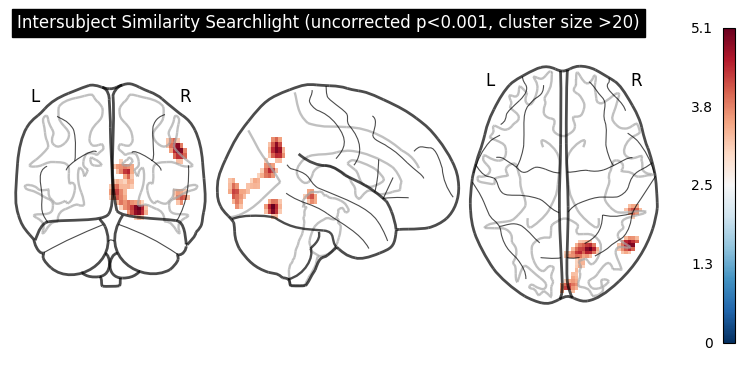

In [ ]:
# visualize cluster + p correction result
display = plotting.plot_glass_brain(
    final_img_t_allthr,
    threshold=0,
    plot_abs=False
)
display.title("Intersubject Similarity Searchlight (uncorrected p<0.001, cluster size >20)", 
              size=12)
plotting.show()

In [28]:
from nilearn.reporting import get_clusters_table
table, label_mask = get_clusters_table(
    final_img_t_allthr,
    stat_threshold=0.001,
    cluster_threshold=0,
    two_sided=False,
    return_label_maps=True
)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,22.00,-66.00,-12.0,5.070570,2147
1,2,52.25,-63.25,32.0,4.925980,1633
2,3,13.75,-68.75,16.0,4.471462,3025
3,3a,2.75,-96.25,0.0,4.275936,
4,3b,13.75,-79.75,8.0,3.506352,
5,4,55.00,-35.75,-4.0,4.170803,665


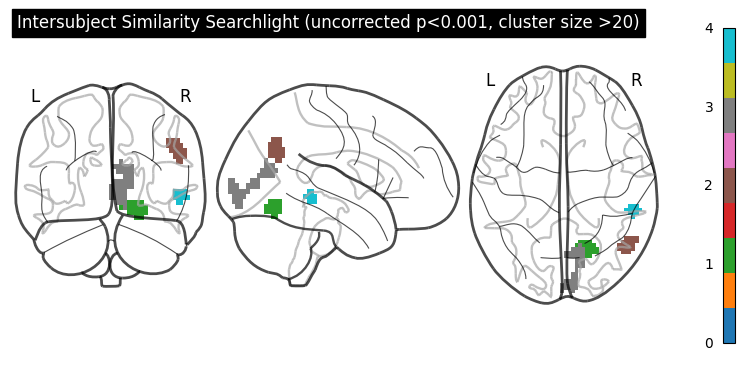

In [29]:
display = plotting.plot_glass_brain(
    label_mask[0],
    threshold=0,
    plot_abs=False,
    cmap='tab10'
)
display.title("Intersubject Similarity Searchlight (uncorrected p<0.001, cluster size >20)", 
              size=12)
plotting.show()

In [30]:
nib.save(label_mask[0], f'Searchlight_ISC_cluster_label_allthr.nii.gz')

In [19]:
# know where peak is (roi)
from nilearn import datasets, image
# get image atlases
atlas_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
# define MNI - voxel transform
def get_label_from_coords(x, y, z):
    # MNI to voxel index in atlas
    # check in cortical first
    idx_cort = image.coord_transform(x, y, z, np.linalg.inv(atlas_cort.maps.affine))
    label_idx_cort = atlas_cort.maps.get_fdata()[int(idx_cort[0]), int(idx_cort[1]), int(idx_cort[2])]
    if label_idx_cort > 0:
        return atlas_cort.labels[int(label_idx_cort)]
    # then in subcortical
    idx_sub = image.coord_transform(x, y, z, np.linalg.inv(atlas_sub.maps.affine))
    label_idx_sub = atlas_sub.maps.get_fdata()[int(idx_sub[0]), int(idx_sub[1]), int(idx_sub[2])]
    if label_idx_sub > 0:
        return atlas_sub.labels[int(label_idx_sub)]
    return "background"

table['roi_label'] = table.apply(lambda row: get_label_from_coords(row['X'], row['Y'], row['Z']), axis=1)
table

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\ell\nilearn_data\fsl

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\ell\nilearn_data\fsl

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),roi_label
0,1,22.00,-66.00,-12.0,5.070570,2147,Occipital Fusiform Gyrus
1,2,52.25,-63.25,32.0,4.925980,1633,"Lateral Occipital Cortex, superior division"
2,3,13.75,-68.75,16.0,4.471462,3025,Intracalcarine Cortex
3,3a,2.75,-96.25,0.0,4.275936,,Occipital Pole
4,3b,13.75,-79.75,8.0,3.506352,,Intracalcarine Cortex
5,4,55.00,-35.75,-4.0,4.170803,665,"Middle Temporal Gyrus, posterior division"


In [20]:
table.to_csv('Searchlight_ISC_cluster_table.csv')

In [21]:
from collections import Counter
coords = np.nonzero(final_img_t_allthr.get_fdata())
cort = nib.load("atlas/cortical_mask_resample.nii.gz").get_fdata()
sub_cort = nib.load("atlas/subcortical_mask_resample.nii.gz").get_fdata()
label_df = pd.read_csv("atlas/region_voxel_summary.csv")
region_counts = Counter()
for i in range(len(coords[0])):
    x, y, z = coords[0][i], coords[1][i], coords[2][i]
    cort_label = cort[x, y, z]
    sub_cort_label = sub_cort[x, y, z]
    if cort_label !=0:
        current_region_id = cort_label
        region_type = "cortical"
    elif sub_cort_label not in [0,1,2,3,12,13,14]:
        current_region_id = sub_cort_label
        region_type = "subcortical"
    else:
        continue
    region_info = label_df[(label_df['id'] == current_region_id) & (label_df['region'] == region_type)]
    if not region_info.empty:
        region_name = region_info['Name'].values[0]
        region_counts[region_name] += 1

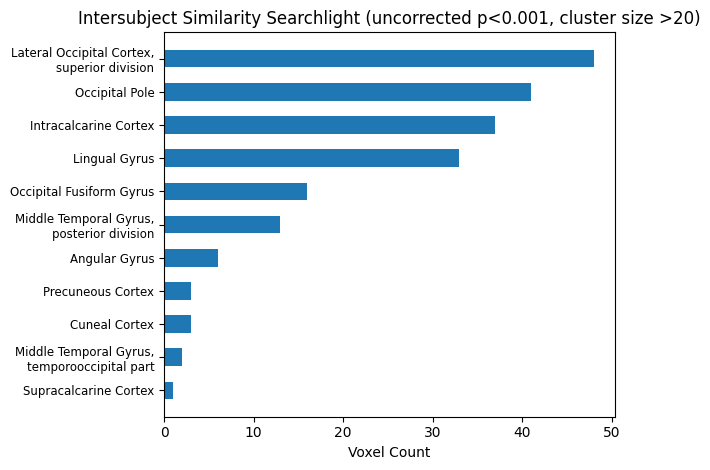

In [25]:
# visualize
import textwrap
result_df = pd.DataFrame({
    'region': list(region_counts.keys()),
    'voxel_count': list(region_counts.values())
}).sort_values('voxel_count', ascending=True) 
plt.figure()
y_pos = np.array(range(len(result_df['region'])))*1.5
plt.barh(y_pos, result_df['voxel_count'])
wrapped_labels = [textwrap.fill(region, width=25) for region in result_df['region']]
plt.yticks(y_pos, wrapped_labels, fontsize=8.5)
plt.title("Intersubject Similarity Searchlight (uncorrected p<0.001, cluster size >20)")
plt.xlabel('Voxel Count')
plt.tight_layout()
plt.show()